Field naming scheme: ztf_YEARMMDD_something-like-field-number_something-filter-like-ccd-number_?_ccd-quadrant-number_info-about-type-of-file.fits.fz.

DO ERROR PROPAGATION FOR MAGTOT

ADD MAGDIFFPOS TO TITLE FOR EVERY PLOT

JUST ADD ANOTHER SUBPLOT OF MAGPSF 

MAYBE ALSO ANNOTATE THE VALUES ON THE MAGTOT PLOT

In [67]:
import os
import io
from typing import *
from tqdm import tqdm
import gzip
import random
import numpy as np
import pandas as pd
import typing
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.style.use('seaborn-whitegrid')
params = {
    'figure.figsize': (10, 7),
    'font.size': 16.0
}
plt.rcParams.update(params)

from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter
import fastavro
import aplpy

from io import BytesIO
import urllib.request

import astropy
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.io import fits
import warnings

warnings.filterwarnings("ignore")

In [2]:
np.array(plt.style.available)


array(['Solarize_Light2', '_classic_test_patch', '_mpl-gallery',
       '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast',
       'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn',
       'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark',
       'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep',
       'seaborn-muted', 'seaborn-notebook', 'seaborn-paper',
       'seaborn-pastel', 'seaborn-poster', 'seaborn-talk',
       'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid',
       'tableau-colorblind10'], dtype='<U20')

# ZTF Survey Data

In [3]:
DATA_DIR = './data'

Let's count packets. Let's use a generator--we could eventually have millions of these alerts to look at!

In [4]:
def find_files(root_dir:str)->list:
    """
    DONE
    Given a root directory, returns a list of files with .avro extension

    Args:
        root_dir (str): Root directory where the search starts

    Returns:
        list: List of file names with .avro extension
    """    
    return [dir_name+'/'+fname for dir_name, subdir_list, file_list in os.walk(root_dir, followlinks=True) for fname in file_list if fname.endswith('.avro')]

In [46]:
files = find_files(DATA_DIR)

In [53]:
# next(open_alert(files[0]))

In [66]:
def open_alert(fname:str)->dict:
    """
    DONE
    Opens each alert using fastavro package

    Args:
        fname (str): Name of the file

    Yields:
        dict: The packet stored in each file
    """    
    with open(fname,'rb') as f:
        freader = fastavro.reader(f)
        for packet in freader:
            yield packet

In [7]:
def is_alert_pure(packet, rb_min=0.65, nbad=0, fwhm_max=5, elong_max=1.2, magdiff_max=None)->bool:
    """
    Function to filter out alerts based on parameters. The defaults have been suggested by the documentation of the survey.

    Documentation of all parameters can be found here: https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html

    Args:
        packet (_type_): _description_
        rb_min (float, optional): Minimum RealBogus quality score; range is 0 to 1 where closer to 1 is more reliable. Defaults to 0.65.
        nbad (int, optional): Number of prior-tagged bad pixels in a 5 x 5 pixel stamp.
        Defaults to 0.
        fwhm_max (int, optional): Maximum Full Width Half Max assuming a Gaussian core, from SExtractor [pixels]. Defaults to 5.
        elong_max (float, optional): Ratio: aimage / bimage. Essentially gives the ellipticity of the image. aimage = Windowed profile RMS afloat major axis from SExtractor [pixels] and bimage = Windowed profile RMS afloat minor axis from SExtractor [pixels]. Defaults to 1.2.
        magdiff_max (float, optional): Difference: magap - magpsf [mag]. Defaults to 0.1.
    Returns:
        pure (bool): Returns True if packet is pure else False
    """    
    pure = True
    if rb_min:
        pure &= packet['candidate']['rb'] >= rb_min
    if nbad:
        pure &= packet['candidate']['nbad'] == nbad
    if fwhm_max:
        pure &= packet['candidate']['fwhm'] <= fwhm_max
    if elong_max:
        pure &= packet['candidate']['elong'] <= elong_max
    if magdiff_max:
        pure &= np.abs(packet['candidate']['magdiff']) <= magdiff_max
    return pure


In [8]:
def make_dataframe(packet:dict, filter:bool =True) -> pd.DataFrame:
    """_summary_

    Args:
        packet (dict): Alert streams from ZTF survey
        filter (bool, optional): Apply filters if True else False. Defaults to False.

    Returns:
        pd.DataFrame: pandas Dataframe created from packet
    """    
    if filter:
        if is_alert_pure(packet):
            packet = packet

    # dataframe of candidates
    dfc = pd.DataFrame(packet['candidate'], index=[0])

    # dataframe of previous candidates
    df_prv = pd.DataFrame(packet['prv_candidates'])

    # concatenated dataframes of information on  candidate and previous candidate
    dflc = pd.concat([dfc, df_prv], ignore_index=True).fillna(value=np.nan)
    
    # sign is +1 if isdiffpos is true else -1
    sign = np.where(np.logical_or(dflc["isdiffpos"] == "t", dflc["isdiffpos"] == 1), 1, -1)

    
    # calculate the flux of the difference image from the magnitude
    diff_flux = sign * np.power(10, (-dflc.magpsf.fillna(value=np.nan))/2.5)
    

    # calculate the flux of the reference image from the magnitude
    ref_flux = np.power(10, (-dflc.magnr.fillna(value=np.nan))/2.5)
    
    # calculate total flux
    tot_flux = ref_flux + diff_flux

    # convert to magnitude
    total_mag = -2.5 * np.log10(tot_flux)
    dflc["magtot"] = total_mag
    # fix this bug to do it separately for r and g bands

    # total_mag = total_mag.fillna(value=np.mean(dflc["magnr"]))

    # print(pd.DataFrame({"difffl": diff_flux,
    #       "reffl": ref_flux, "totfl": tot_flux, "magtot": total_mag}))

    dflc[dflc["fid"] == 1]["magtot"] = total_mag.fillna(
        value=np.mean(dflc[dflc["fid"] == 1]["magnr"]))
    dflc[dflc["fid"] == 2]["magtot"] = total_mag.fillna(
        value=np.mean(dflc[dflc["fid"] == 1]["magnr"]))

    # put a filter on max not nan values to be 20? ****
    # if dflc["magpsf"].count() < 20:
    #     return pd.DataFrame()

    #### throw away data with ref star more than 1 arcsec away
    if np.nanmean(dflc.magtot) > 20:
        return pd.DataFrame()
        
    # we'll attach some metadata--not this may not be preserved after all operations
    # https://stackoverflow.com/questions/14688306/adding-meta-information-metadata-to-pandas-dataframe
    
    dflc.objectId = packet['objectId']
    dflc.candid = packet['candid']
    return pd.DataFrame() if len(dflc.columns) == 0 else dflc

In [9]:
# next(open_alert(files[2]))["cutoutTemplate"]


In [10]:
df = make_dataframe(next(open_alert(files[20])))
# # x.loc[:, ["magpsf", "magnr", "magtot", "diffmaglim", "isdiffpos"]]
# max(df.jd)

In [11]:
def plot_lightcurve_magpsf(dflc: pd.DataFrame, ax=None, days_ago: bool=True) -> None:
    """
    Plot lightcurve from the packet information.

    Args:
        dflc (pd.DataFrame): pandas Dataframe created from packet information
        ax (_type_, optional): Matplotlib axes for plot. Defaults to None.
        days_ago (bool, optional): Plot with x-axis as days_ago else just julian date. Defaults to True.
    """    
    if len(dflc.columns) == 0:
        return
    filter_color = {1: 'green', 2: 'red', 3: 'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.jd - now
        dayOfCreation = Time(max(dflc['jd']), format='jd').isot.split("T")[0]
        xlabel = f"Days since {dayOfCreation}"
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'

    if ax is None:
        plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid)
        if np.sum(w):
            plt.errorbar(t[w], dflc.loc[w, 'magpsf'],
                         dflc.loc[w, 'sigmapsf'], fmt='.', color=color, label=f"{color[0]}-filter detection")

        
        closeToNearestSource = (dflc.fid == fid) & (dflc.distnr < 2)
        if closeToNearestSource.any():
            plt.axhline(y=np.nanmean(dflc.loc[closeToNearestSource, 'magnr']),linestyle = '--', color=color)
            
            
        wnodet = (dflc.fid == fid) & dflc.magpsf.isnull() 
        if np.sum(wnodet):
            # diffmaglim - 5-sigma mag limit in difference image 
            # based on PSF-fit photometry [mag]
            plt.scatter(t[wnodet], dflc.loc[wnodet, 'diffmaglim'],
                        marker='v', color=color, alpha=0.25, label=f"{color[0]}-filter upper limit")


    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Difference Magnitude (magpsf)')


In [12]:
def plot_lightcurve_magtot(dflc: pd.DataFrame, ax=None, days_ago: bool=True) -> None:
    """
    Plot lightcurve from the packet information.

    Args:
        dflc (pd.DataFrame): pandas Dataframe created from packet information
        ax (_type_, optional): Matplotlib axes for plot. Defaults to None.
        days_ago (bool, optional): Plot with x-axis as days_ago else just julian date. Defaults to True.
    """    
    if len(dflc.columns) == 0:
        return
    filter_color = {1: 'green', 2: 'red', 3: 'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.jd - now
        dayOfCreation = Time(max(dflc['jd']), format='jd').isot.split("T")[0]
        xlabel = f"Days since {dayOfCreation}"
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'

    if ax is None:
        plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid)
        if np.sum(w):
            plt.scatter(t[w], dflc.loc[w, 'magtot'], marker='.', color=color, label = f"{color[0]}-filter detection")
        
        closeToNearestSource = (dflc.fid == fid) & (dflc.distnr < 2)
        if closeToNearestSource.any():
            plt.axhline(y=np.nanmean(dflc.loc[closeToNearestSource, 'magnr']),linestyle = '--', color=color)
            
            
        wnodet = (dflc.fid == fid) & dflc.magpsf.isnull() 
        if np.sum(wnodet):
            # diffmaglim - 5-sigma mag limit in difference image 
            # based on PSF-fit photometry [mag]
            plt.scatter(t[wnodet], dflc.loc[wnodet, 'magnr'],
                        marker='v', color=color, alpha=0.25, label = f"{color[0]}-filter upper limit")
                        
    for i in range(len(dflc)):
        if dflc.isdiffpos.fillna("")[i] != "":
            plt.text(t[i], dflc.loc[i, 'magtot']-0.005, f"{dflc.isdiffpos[i]}")


    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Total Magnitude (magtot)')


In [13]:
def plot_cutout(stamp: bytes, sign: int = 1, fig=None, subplot=None, **kwargs) -> aplpy.core.FITSFigure:
    """
    Plot cutout images - Science, Reference, and Difference images

    Args:
        stamp (_type_): _description_
        sign (int, optional): _description_. Defaults to 1.
        fig (_type_, optional): _description_. Defaults to None.
        subplot (_type_, optional): _description_. Defaults to None.

    Returns:
        aplpy.core.FITSFigure: _description_
    """    
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            with fits.open(io.BytesIO(f.read())) as hdul:
                if fig is None:
                    fig = plt.figure(figsize=(4, 4))
                if subplot is None:
                    subplot = (1, 1, 1)
                ffig = aplpy.FITSFigure(
                    sign * hdul[0].data, figure=fig, subplot=subplot,**kwargs)
                ffig.show_grayscale(stretch='arcsinh')
                # ffig.add_colorbar()
                # ffig.colorbar.set_location('bottom')
                # ffig.colorbar.set_pad(0.5)
                # ffig.colorbar.set_font(size=8, weight='medium',
                #                       stretch='normal', family='sans-serif',
                #                       style='normal', variant='normal')

        return ffig

In [14]:
def show_stamps(packet: dict) -> None:
    fig = plt.figure(figsize=(12, 4))
    for i, cutout in enumerate(['Science', 'Template', 'Difference']):
        stamp = packet[f'cutout{cutout}']['stampData']
        ffig = plot_cutout(stamp, fig=fig, subplot=(1, 3, i+1))
        ffig.set_title(cutout)


In [15]:

def show_all(packet: dict, show_plot: bool = False) -> matplotlib.figure.Figure:
    dflc = make_dataframe(packet)
    if len(dflc.columns) == 0:
        return None
    fig = plt.figure(figsize=(16, 4))
    plot_lightcurve_magpsf(dflc, ax=plt.subplot(1, 5, 1))
    plot_lightcurve_magtot(dflc, ax=plt.subplot(1, 5, 2))
    sign = 1
    for i, cutout in enumerate(['Science', 'Template', 'Difference']):
        stamp = packet['cutout{}'.format(cutout)]['stampData']
        if cutout == 'Difference':
            sign = -1 if (0 in dflc.isdiffpos.values or "f" in dflc.isdiffpos.values) else 1
        ffig = plot_cutout(stamp, sign = sign, fig=fig, subplot=(1, 5, i+3))
        ffig.set_title(cutout)
    fig.suptitle(f"ObjectID: {dflc.objectId} | ObjectRA: {np.nanmean(dflc.ra):.5f} | ObjectDEC: {np.nanmean(dflc.dec):.5f}")
    fig.tight_layout()
    if not show_plot:
        plt.close(fig)
    return fig


In [16]:
import random


def export_lightcurves_to_pdf(savefilepath: str = "plots/", savefilename: str = 'ZTFalerts20210608', choose_random: bool = True, limit: int = 100) -> None:
    plt.ioff()

    filename_list = find_files(DATA_DIR)
    if not limit:
        limit = len(filename_list)
    if choose_random:
        savedFileName = savefilepath+savefilename+"_randomSampled.pdf"
        filename_list = random.choices(filename_list, k=limit)
    else:
        savedFileName = savefilepath+savefilename+".pdf"


    with PdfPages(savedFileName) as pdf:
        for fname in tqdm(filename_list):
            alert = next(open_alert(fname))
            fig = show_all(alert,
             show_plot=False)
            if fig:
                pdf.savefig(fig)


In [17]:
# export_lightcurves_to_pdf(choose_random=True, limit=50)

In [18]:
def get_gal_coordinates(filename_list:list=find_files(DATA_DIR), limit=None):
    '''
    Create a figure and axes
    Open every packet
    Get RA and DEC
    Convert to galactic coordinates
    Plot them
    '''
    if not limit:
        lim = len(filename_list)
    else:
        lim = limit

    l_arr, b_arr = np.ones(lim), np.ones(lim)

    for i, fname in enumerate(tqdm(filename_list[:lim])):
        alert = next(open_alert(fname))
        ra, dec = alert["candidate"]["ra"], alert["candidate"]["dec"]
        c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
        l_arr[i], b_arr[i] = c_icrs.galactic.l.value, c_icrs.galactic.b.value
    alertnight = Time(alert["candidate"]["jd"], format="jd").isot.split("T")[0]
    return l_arr, b_arr, alertnight

In [19]:
# l, b, alert_night = get_gal_coordinates(limit=None)
# fig, ax = plt.subplots(figsize=(20, 12))
# ax.scatter(l, b, marker="+", c="r", s=150, alpha=0.7)
# ax.set_xlabel("Galactic Longitude (l)", fontsize=20)
# ax.set_ylabel("Galactic Lattitude (b)", fontsize=20)
# ax.set_title(f"Alerts for {alert_night}", fontsize=25)
# ax.tick_params(axis='x', labelsize=20)
# ax.tick_params(axis='y', labelsize=20)
# fig.tight_layout()
# fig.savefig(f"plots/galactic_coords_{alert_night}.jpg")


# IPAC Data for Comparison

Link: <a href="https://irsa.ipac.caltech.edu/Missions/ztf.html"> IPAC Website </a>

In [20]:
# def read_ipac_data_byID(ID: int = 1619436163215010044, radius:float = 5):
#     radius_in_deg = radius / 3600
#     base_url = f"https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20{ra}%20{dec}%20{radius_in_deg}&BANDNAME="

#     ipac_data_r = urllib.request.urlopen(
#         f'{base_url}r').read()
# #https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20{ra}%20{dec}%200.0014&BANDNAME=r&TIME=-Inf 55555.5
# #&TIME=59373%2059385
#     ipac_data_g = urllib.request.urlopen(
#         f'{base_url}g').read()

#     red_filter = Table.read(BytesIO(ipac_data_r))
#     red_filter["filter"] = np.array(["r"] * len(red_filter),dtype="U1")

#     green_filter = Table.read(BytesIO(ipac_data_g))
#     green_filter["filter"] = np.array(["g"] * len(green_filter), dtype="U1")


#     return vstack([red_filter, green_filter])
    


In [21]:
def read_ipac_data(ra: float = 197.63048, dec: float = 36.84845, radius: float = 10) -> Optional[astropy.table.table.Table]:
    # API: https://irsa.ipac.caltech.edu/docs/program_interface/ztf_lightcurve_api.html
    # 5 arcsec = 0.0014 deg
    radius_in_deg = radius / 3600
    base_url = f"https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20{ra}%20{dec}%20{radius_in_deg}&BANDNAME="

    ipac_data_r = urllib.request.urlopen(
        f'{base_url}r').read()
#https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20{ra}%20{dec}%200.0014&BANDNAME=r&TIME=-Inf 55555.5
#&TIME=59373%2059385
    ipac_data_g = urllib.request.urlopen(
        f'{base_url}g').read()

    print("Data pulled from IPAC")
    
    red_filter = Table.read(BytesIO(ipac_data_r))
    red_filter["filter"] = np.array(["r"] * len(red_filter),dtype="U1")

    green_filter = Table.read(BytesIO(ipac_data_g))
    green_filter["filter"] = np.array(["g"] * len(green_filter), dtype="U1")

    data = vstack([red_filter, green_filter])
    if len(data) > 0:
        times_dt = Time(data["hjd"], format='jd').isot.astype('datetime64[D]', copy=False)
        data["timediff"] = times_dt - times_dt[0]
        return data
    else:
        print("No data found at the coordinates: RA: {ra} | DEC : {dec} with Radius: {radius} arcsec")
        return

In [22]:
# x = read_ipac_data(296.78689, 76.80005)
# x

In [23]:
def plot_lightcurve_ipac_data(dflc: astropy.table.table.Table, ax: Optional[plt.Axes] = None, days_ago: bool = True) -> matplotlib.figure.Figure:
    """
    Plot lightcurve from the ZTF ipac data.

    Args:
        dflc (pd.DataFrame): pandas Dataframe created from packet information
        ax (_type_, optional): Matplotlib axes for plot. Defaults to None.
        days_ago (bool, optional): Plot with x-axis as days_ago else just julian date. Defaults to True.
    """    
    if len(dflc.colnames) == 0:
        return
    filter_color = {'g': 'green', 'r': 'red'}
    if days_ago:
        now = Time.now().jd
        t = dflc["hjd"] - now
        dayOfCreation = Time(max(dflc['hjd']), format='jd').isot.split("T")[0]
        xlabel = f"Days since {dayOfCreation}"
    else:
        t = dflc['hjd']
        xlabel = 'Time (JD)'

    if ax is None:
        fig, ax = plt.subplots()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc["filter"] == fid)
        if np.sum(w):
            ax.errorbar(t[w], dflc[w]['mag'],
                         dflc[w]['magerr'], fmt='.', color=color, alpha=0.4)


    ax.invert_yaxis()
    # ax.set_xlim((-390, -380))
    ax.set_xlabel(xlabel)
    ax.grid()
    ax.set_ylabel('Magnitude')
    ax.set_title(f"ObjectRA: {np.nanmean(dflc['ra']): .5f} | ObjectDEC: {np.nanmean(dflc['dec']): .5f}")
    plt.close(fig)
    return fig

In [24]:
# ra_range = np.arange(110, 120, 1, dtype=np.float32)
# with PdfPages('./plots/ipac_cat.pdf') as pdf:
#     for ra in tqdm(ra_range):
#         try:
#             fig = plot_lightcurve_ipac_data(read_ipac_data(ra=ra, dec=0))
#             if fig:
#                 pdf.savefig(fig)
#         except:
#             print(f"ra={ra}, dec={0} not valid")

In [76]:
def plotToCheckTransformation(dflc: astropy.table.table.Table, dflc2, ax: Optional[plt.Axes] = None, days_ago: bool = True):
    """
    Plot lightcurve from the ZTF ipac data.

    Args:
        dflc (pd.DataFrame): pandas Dataframe created from packet information
        ax (_type_, optional): Matplotlib axes for plot. Defaults to None.
        days_ago (bool, optional): Plot with x-axis as days_ago else just julian date. Defaults to True.
    """
    if not dflc:
        return
    filter_color = {'g': 'green', 'r': 'red'}
    if days_ago:
        now = Time.now().jd
        t = dflc["hjd"] - now
        dayOfCreation = Time(max(dflc['hjd']), format='jd').isot.split("T")[0]
        xlabel = f"Days since {dayOfCreation}"
    else:
        t = dflc['hjd']
        xlabel = 'Time (JD)'

    if ax is None:
        fig, ax = plt.subplots()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc["filter"] == fid)
        if np.sum(w):
            ax.errorbar(t[w], dflc[w]['mag'],
                        dflc[w]['magerr'], fmt='.', color=color, alpha=0.4, label=f"{color[0]}-filter detection | ori")

# plot 2
    filter_color = {1: 'green', 2: 'red', 3: 'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc2.jd - now
        dayOfCreation = Time(max(dflc2['jd']), format='jd').isot.split("T")[0]
        xlabel = f"Days since {dayOfCreation}"
    else:
        t = dflc2.jd
        xlabel = 'Time (JD)'

    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc2.fid == fid)
        if np.sum(w):
            plt.scatter(t[w], dflc2.loc[w, 'magtot'], marker='^',
                        color=color, label=f"{color[0]}-filter detection | tr", alpha=0.3)

    ax.legend(bbox_to_anchor=(1.001, 1.01), loc="upper left")
    ax.invert_yaxis()
    ax.set_xlim((-380, -410))
    ax.set_xlabel(xlabel)
    ax.grid()
    ax.set_ylabel('Magnitude')
    ax.set_title(
        f"ObjectRA: {np.nanmean(dflc['ra']): .5f} | ObjectDEC: {np.nanmean(dflc['dec']): .5f}")
    fig.tight_layout()
    return fig


./data/ztf_public_20210608/1619436163215010044.avro
Data pulled from IPAC


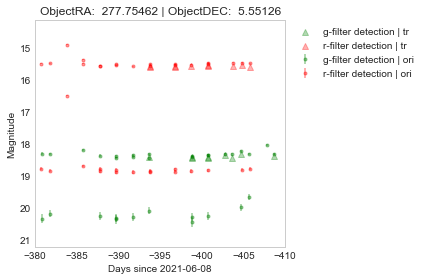

In [65]:
df = make_dataframe(next(open_alert(files[20])))
if len(df) != 0:
    ipac = read_ipac_data(
        ra=max(df["ra"]), dec=max(df["dec"]), radius=5)
    fig = plotToCheckTransformation(dflc=ipac, dflc2=df)


In [71]:
from tqdm import trange

def createComparePlots(files):
    with PdfPages("./plots/comparisonFigs.pdf") as pdf:
        for i in trange(len(files)):
            df = make_dataframe(next(open_alert(files[i])))
            if len(df) != 0:
                ipac = read_ipac_data(
                    ra=max(df["ra"]), dec=max(df["dec"]), radius=5)
                fig = plotToCheckTransformation(dflc=ipac, dflc2=df)
                if fig:
                    pdf.savefig(fig)

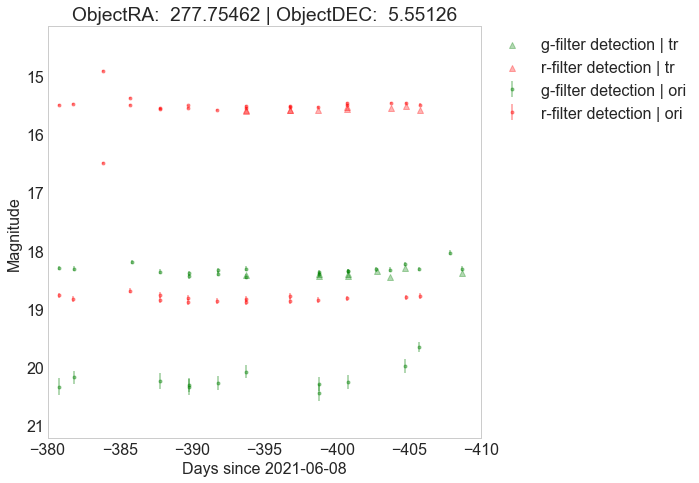

In [77]:
plotToCheckTransformation(dflc=ipac, dflc2=df)


['./data/ztf_public_20210608/1619385995015010010.avro', './data/ztf_public_20210608/1619450653715010019.avro', './data/ztf_public_20210608/1619365492515015016.avro', './data/ztf_public_20210608/1619454275015010023.avro', './data/ztf_public_20210608/1619419272015015029.avro']


  0%|          | 0/5 [00:00<?, ?it/s]

0
./data/ztf_public_20210608/1619385995015010010.avro
0
Data pulled from IPAC


 20%|██        | 1/5 [02:02<08:11, 122.94s/it]

1
./data/ztf_public_20210608/1619450653715010019.avro
1
Data pulled from IPAC


 40%|████      | 2/5 [04:02<06:03, 121.13s/it]

2
./data/ztf_public_20210608/1619365492515015016.avro
2


 60%|██████    | 3/5 [05:48<03:48, 114.20s/it]

Data pulled from IPAC
No data found at the coordinates: RA: {ra} | DEC : {dec} with Radius: {radius} arcsec
3
./data/ztf_public_20210608/1619454275015010023.avro
3
Data pulled from IPAC


 80%|████████  | 4/5 [07:58<02:00, 120.32s/it]

4
./data/ztf_public_20210608/1619419272015015029.avro
4
Data pulled from IPAC


100%|██████████| 5/5 [09:44<00:00, 116.96s/it]


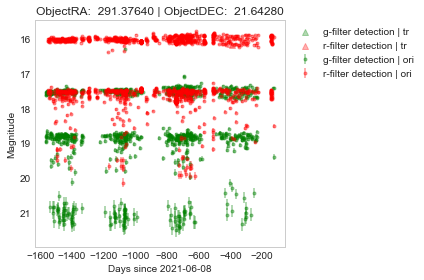

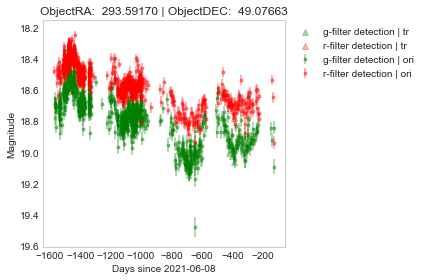

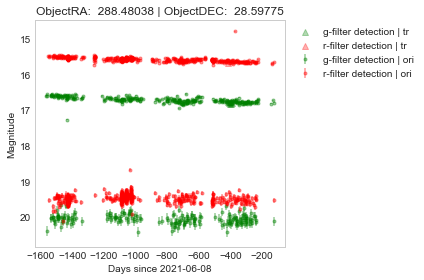

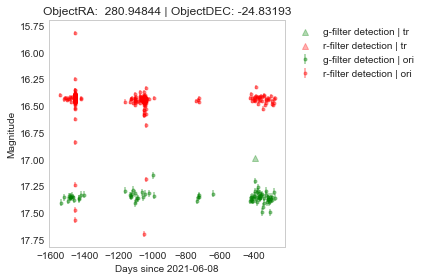

In [63]:
createComparePlots(files[:5])

* Next, just query for a bigger range of RA-DEC-Radius for flat light-curves
* Inject Gravitational Lensing into half of these flat light curves and leave the other half as they are.
* Then apply transformations to all the data in the previous step so they are similar to the alerts and make sure you make the last point have a 5 sigma difference like all the latest night's alerts do
* Divide all the data using train-test split and make model

In [160]:
def flux_pspl(u0, t, t0, tE, F_S, F_B):
    """
    Magnification factor for flux of point source due to a point lens (PSPL model).
    The true flux from the point source is magnified by the point lens by the mean_function and
    as a result can be used to detect faint (or MACHO) objects in the universe

    Source: https://www.microlensing-source.org/concept/point-lenses/
            https://www.microlensing-source.org/glossary/

    Args:
        u0 (_type_): the impact parameter between the source and the lens 
        (i.e. minimum separation)
        t (_type_): time
        t0 (_type_): the time of closest approach between the source and lens
        (i.e. at t = t0, u = u0)
        tE (_type_): the Einstein crossing time = the time for the source to travel 1 Einstein radius
        F_S (_type_): Flux received from the source (as opposed to F_B)
        F_B (_type_): Flux from background sources blended with the source.
    # rename?
    Returns:
        _type_: Magnification factor of the brigtness from point source due to the point lens
    """
    tau = (t-t0)/tE  # represents the fraction of event time that has already passed
    u = np.sqrt(np.square(u0) + (np.square(tau)))
    return F_S * (np.square(u) + 2)/(u * np.sqrt(np.square(u) + 4)) + F_B

In [161]:
def plotGravLensingSimulation(flux, savefig = False):

    plt.scatter(t, -2.5 * np.log10(flux), alpha=0.6, s=15)
    plt.xlabel("Time (days)")
    plt.ylabel("Magnitude (mag)")
    plt.ticklabel_format(useOffset=False)
    plt.gca().invert_yaxis()
    if savefig:
        plt.savefig("plots/simMicroLensEvent.jpg")


In [74]:
# bigraddata = read_ipac_data(36, 10, 20)


Data pulled from IPAC


In [162]:
# np.unique(bigraddata["oid"], return_counts=True)

In [163]:
# plot_lightcurve_ipac_data(bigraddata)

In [164]:
steps = 36
low, high = 0, 360+360  # degrees
dec = 10

x = read_ipac_data(36, dec, 10)

Data pulled from IPAC


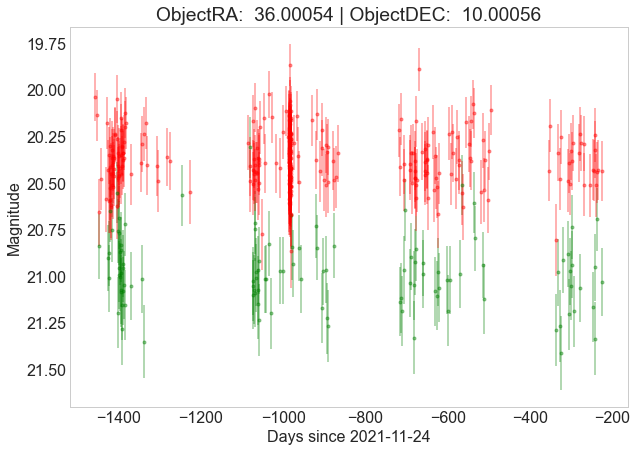

In [165]:
plot_lightcurve_ipac_data(x)

### CHANGE FORMULA TO WORK FOR MAGNITUDES 

Change the F_S for the r and g bands

pick t_e, make t to be the last day of the batch and then calculate t0

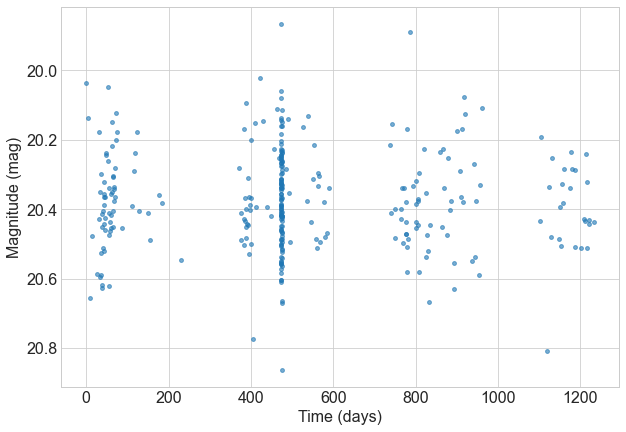

In [168]:
r = x[x["filter"] == "r"]
t = r["timediff"].astype(np.int32)
lc_flux = np.power(10, -r["mag"]/2.5)
# lc = r["mag"]

F_S = np.median(lc)
F_B = 0
t0 = np.mean(t) # np.random.normal(loc=np.mean(lc), scale=100) # in days
tE = 1  # t_E = np.random.uniform(low = 0, high = 0)
u0 = np.random.uniform(low=0, high=2)

pspl = flux_pspl(u0, t, t0, tE, F_S, F_B)
tot_flux = pspl - F_S + lc_flux

plotGravLensingSimulation(tot_flux, savefig=False)

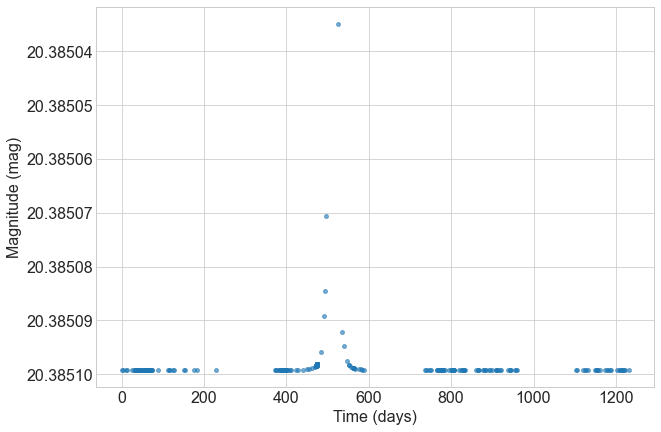

In [169]:
plotGravLensingSimulation(pspl, savefig=False)

In [68]:
u0

1.9252957010604377

Some thoughts:

* Since we are injecting gravitational lensing events, we need to make sure we choose parameters that have the highest likelihood given the average parameters we observe for this events, i.e. we need to ensure that our gravitational lensing distribution is 'good' one since the model will learn from that. So if we don't generalize the distribution well it will not be able to detect events well.

* I assume that since the distribution is from the function above, we need to make sure that the parameters we set are generalized ones

* Time steps: I think I finally understand why irregularity is a pain to deal with. Obviously it's difficult to understand how the advanced algorithms learn right? But I feel like if the algorithm tries to learn from the irregularity of the data we might have some issues. I don't understand Deep Learning algorithms incredibly well enough to give my proper opinion or thoughts on this but I feel like that might be a concern.